# Factor Risk Exposure

Yan Wu<br/>
yanwu26@gmail.com</br>

Repurposed items from http://www.quantopian.com/posts and concepts from "Active Portfolio Management" by Richard Grinold and Ronald Kahn, whom I was incredibly lucky to have worked under early in my career. Quantopian has the best resources in the world for quant investors!

## Using Factor Models to Determine Risk Exposure

Expanding on my Fama French notebook concepts, we must understand that the exposures move quite a bit throughout time. This notebook will go into detail of how risk is decomposed using Marginal Contribution to Active Risk, and then see just how volatile the systematic risks manifests itself in the portfolio.

Using linear regression models to analyze the sources of risks in portfolios as follows:

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$$

Regressing historical returns, we can approximate how much of the portfolio variance is due to speculation on systematic factors and how much is idiosyncratic ($\epsilon_p$). In risk analytics, we model active returns (excess over benchmark) and active risk (standard deviation of excess returns, also known as tracking error).

For instance, we can find a factor's marginal contribution to active risk squared (FMCAR). For factor $j$, this is

$$ \text{FMCAR}_j = \frac{b_j^a \sum_{i=1}^K b_i^a Cov(F_j, F_i)}{(\text{Active risk})^2} $$

where $b_i^a$ is the portfolio's active exposure to factor $i$. This tells us how much risk we incur by being exposed to factor $j$, given all the other factors we're already exposed to.

Fundamental factor models are often used to evaluate portfolios because they correspond directly to investment choices (e.g. whether we invest in small-cap or large-cap stocks, etc.). Below, we construct a model to evaluate a single asset; for more information on the model construction, check out the fundamental factor models notebook.

We'll use the canonical Fama-French factors for this example, which are the returns of portfolios constructred based on fundamental factors.

## As many factors as you can find!

When it comes to factor risks, we want to find as many factors as possible that can systematically explain the movements of a portfolio. Anything left over is considered $\alpha$ as it is unexplained by the selected factors. Ideally, we want the $\alpha$ to be stable, so that we can systematically hedge out all factor risks and exploit our money making machine. In reality, it is incredibly difficult to consistently add alpha over a long time period :)

In [17]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
from datetime import datetime, timedelta
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
%matplotlib inline
params = {'legend.fontsize': 'x-large','figure.figsize': (15, 10),'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}#,'axes.facecolor': 'white'}
pylab.rcParams.update(params)

In [3]:
## Helper function to get prices from Yahoo
def get_historical_closes(ticker, start_date, end_date):
    # get the data for the tickers.  This will be a panel
    p = wb.DataReader(ticker, "yahoo", start_date, end_date)    
    # convert the panel to a DataFrame and selection only Adj Close
    # while making all index levels columns
    d = p.to_frame()['Adj Close'].reset_index()
    # rename the columns
    d.rename(columns={'minor': 'Ticker', 'Adj Close': 'Close'}, inplace=True)
    # pivot each ticker to a column
    pivoted = d.pivot(index='Date', columns='Ticker')
    # and drop the one level on the columns
    pivoted.columns = pivoted.columns.droplevel(0)
    return pivoted

### Get Data For Analysis

In [9]:
# Set relevant dates
start_date = '2014-10-31'
end_date = '2016-10-31'

# Get Fama Factors 
url = urlopen("http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip")
#Download Zipfile and create pandas DataFrame
zipfile = ZipFile(BytesIO(url.read()))
df = pd.read_csv(zipfile.open('F-F_Research_Data_Factors_daily.CSV'), header = 0, names = ['asof_dt','MKT-RF','SMB','HML','RF'], skiprows=3).dropna()
df['asof_dt'] = pd.to_datetime(df['asof_dt'], format = "%Y%m%d")
df=df.set_index('asof_dt', drop=True)
df=df[(df.index>=start_date) & (df.index<=end_date)]
df=df/100 #convert to percentage
df.head(5)

# Get returns data for our portfolio
portfolio = get_historical_closes(['MSFT', 'AAPL', 'YHOO', 'FB', 'TSLA'], start_date=start_date, end_date=end_date).pct_change()[1:]
R = pd.DataFrame(np.mean(portfolio, axis=1))
R.columns=['ret'] ##rename returns

##add to FF dataframe
df_tot=pd.concat([df,R], axis=1)
df_tot['ret_excess']=df_tot['ret']-df_tot['MKT-RF']-df_tot['RF'] ##RETURN MINUS MARKET-RF - RF
df_tot=df_tot.dropna()
df_tot.head(5)

,MKT-RF,SMB,HML,RF,ret,ret_excess
2014-11-03,-0.0001,-0.0025,-0.0005,0.0,0.003715,0.003815
2014-11-04,-0.0035,-0.0003,-0.0011,0.0,0.004351,0.007851
2014-11-05,0.0048,-0.0054,0.0085,0.0,-0.005806,-0.010606
2014-11-06,0.0049,0.0009,-0.0049,0.0,0.016088,0.011188
2014-11-07,0.0009,0.0000,0.0044,0.0,0.003133,0.002233


### How did each factor do since 2016?

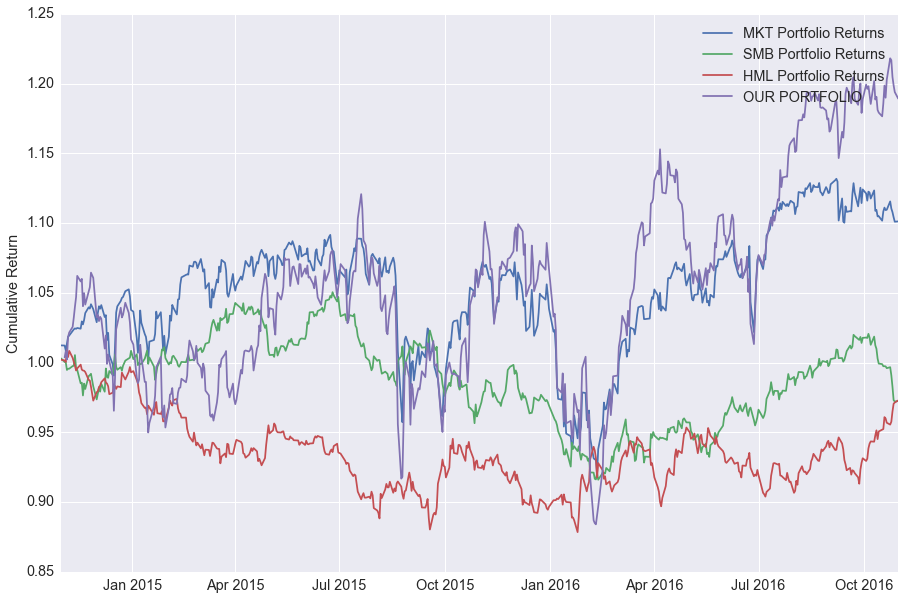

In [12]:
MKT_CUM = np.cumprod(df['MKT-RF']+1)
SMB_CUM = np.cumprod(df.SMB+1)
HML_CUM = np.cumprod(df.HML+1)
PORT_CUM = np.cumprod(R+1)

plt.plot(MKT_CUM.index, MKT_CUM.values)
plt.plot(SMB_CUM.index, SMB_CUM.values)
plt.plot(HML_CUM.index, HML_CUM.values)
plt.plot(PORT_CUM.index, PORT_CUM.values)

plt.ylabel('Cumulative Return')
plt.legend(['MKT Portfolio Returns','SMB Portfolio Returns', 'HML Portfolio Returns','OUR PORTFOLIO'])
#plt.legend(['SMB Portfolio Returns', 'HML Portfolio Returns']);

## Computing Risk Exposure


As we did in the Fama French notebook, we do this by running a linear regression of our excess return stream with the Fama French systematic factors.

### Run Regression Model

In [14]:
X=df_tot.ix[:,[1,2]]
X=sm.add_constant(X) ## add constant for intercept
y=df_tot['ret_excess']

# run model
model=sm.OLS(y, X)
results = model.fit()

#output results and parameters
print(results.summary())
print(results.params)

                            OLS Regression Results                            
Dep. Variable:             ret_excess   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     40.89
Date:                Tue, 29 Nov 2016   Prob (F-statistic):           3.57e-17
Time:                        17:19:37   Log-Likelihood:                 1759.1
No. Observations:                 503   AIC:                            -3512.
Df Residuals:                     500   BIC:                            -3499.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0002      0.000      0.567      0.5

In [344]:
##get parameters from model
_, b1,b2 = results.params

F1 = df_tot['SMB']
F2 = df_tot['HML']
cov = np.cov(F1, F2)
ar_squared = (df_tot['ret_excess'].std())**2
fmcar1 = (b1*(b2*cov[0,1] + b1*cov[0,0]))/ar_squared
fmcar2 = (b2*(b1*cov[0,1] + b2*cov[1,1]))/ar_squared
print ('Total Active Volatility (STD):', (ar_squared**0.5)*(255**0.5))
print ('SMB Risk Contribution:', fmcar1)
print ('HML Risk Contribution:', fmcar2)
print ('Total Percent of Systematic Risk:', fmcar1+fmcar2)
print ('Total Percent of Idiosyncratic Risk:', 1-fmcar1-fmcar2)

Total Active Volatility (STD): 0.1263466646402061
SMB Risk Contribution: -0.00024878225357
HML Risk Contribution: 0.140821288997
Total Percent of Systematic Risk: 0.140572506744
Total Percent of Idiosyncratic Risk: 0.859427493256


### Marginal Contribution to Risk Over Time

We need to be mindful as the systematic factors change over time.

C:\Users\ywu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)


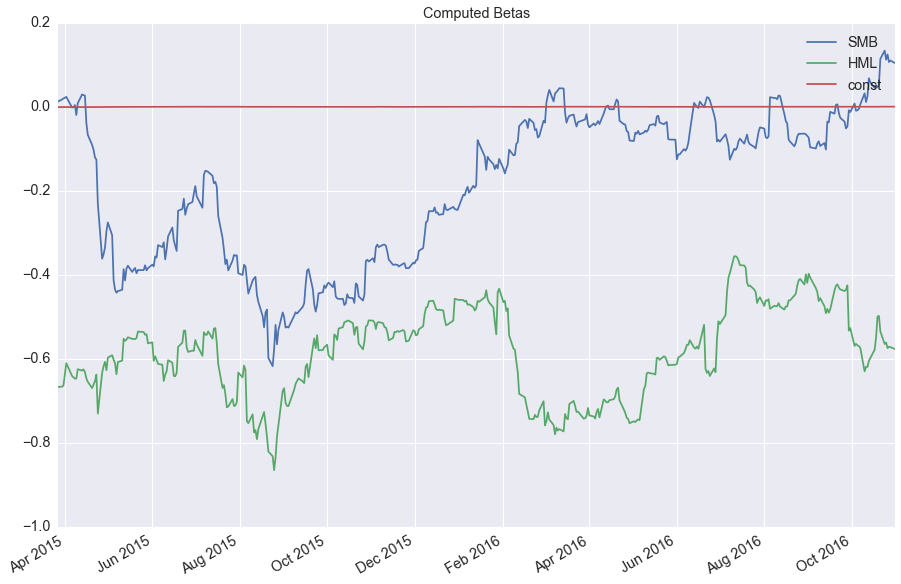

In [16]:
# Compute the rolling betas
model = pd.stats.ols.MovingOLS(y = y, x=X, window_type='rolling', window=100)
#model = pd.stats.ols.MovingOLS(y = df_tot['ret_excess'], x=df[['SMB', 'HML']], window_type='rolling', window=100)
betas_rolling = model.beta.ix[:,[1,2,0]]
betas_rolling.plot();
plt.title('Computed Betas');
plt.legend(betas_rolling.columns);

C:\Users\ywu\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_cov is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100).cov(other=<DataFrame>,pairwise=True)
  from ipykernel import kernelapp as app
C:\Users\ywu\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=100).std()
  app.launch_new_instance()


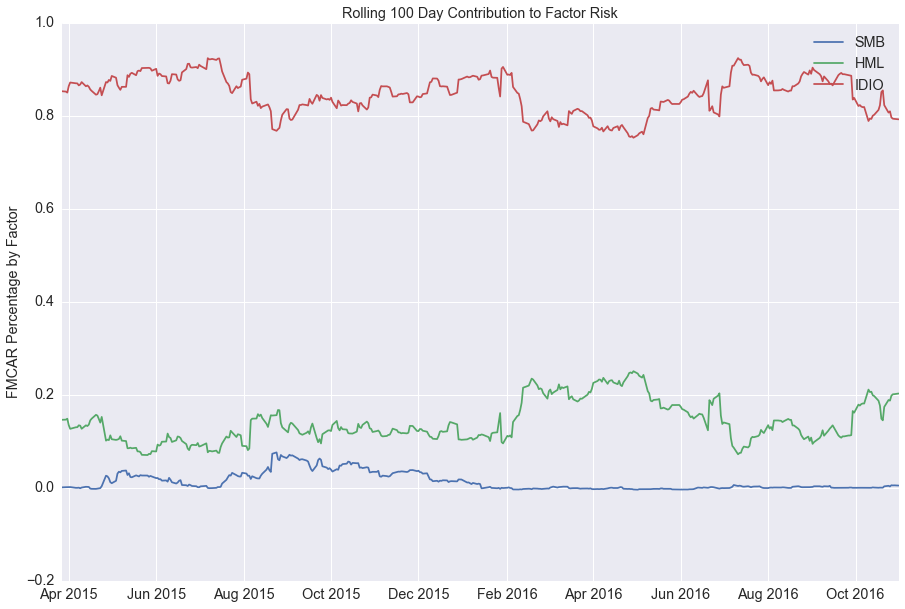

In [24]:
#df_tot[['SMB','HML']]
cov_r = pd.rolling_cov(df_tot[['SMB', 'HML']], window=100)[99:]
ar_squared_r = pd.rolling_std(df_tot['ret_excess'], window = 100)[99:]**2
betas_r = betas_rolling[['SMB', 'HML']]

FMCAR = pd.DataFrame(index=betas_r.index, columns=betas_r.columns)

# For each factor
for factor in betas_r.columns:
    # For each bar in our data
    for t in betas_r.index:
        # Compute the sum of the betas and covariances
        s = np.sum(betas_r.loc[t] * cov_r[t][factor])
        # Get the beta
        b = betas_r.loc[t][factor]
        # Get active risk squared
        AR = ar_squared_r.loc[t]
        # Put them all together to estimate FMCAR on that date
        FMCAR[factor][t] = b * s / AR

FMCAR['IDIO']=1-FMCAR['SMB']-FMCAR['HML']
# Plot FMCAR
        
plt.plot(FMCAR.index, FMCAR.values)
#plt.plot(FMCAR['F2'].index, FMCAR['F2'].values)
plt.title('Rolling 100 Day Contribution to Factor Risk')
plt.ylabel('FMCAR Percentage by Factor')
plt.legend(FMCAR.columns);

### Conclusion

Factor Risk Exposures change throughout time. It's important to keep in mind that these risks are still only estimates based on past observations. 

When assessing this portfolio, we see that a large portion of the model has a very low R-Squared of 14.5%, which suggests that most of the active risk, 85.5% is coming from stock specific risk. We also see throughout time, that while the idiosyncratic risk hovers between 70%-95%. In portfolio construction, this is actually very good; we want the most amount of risk to be idiosyncratic risk (active bets).

That being said, taking big active bets is good if your prediction model works...but that's the million (or billion) dollar question. :) Good luck!